<a href="https://colab.research.google.com/github/reibek/progn-semestral-work/blob/main/Progonstics_Semestral_work_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/FRI/PROGN/SK_TAVG_Trend.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data insight

Data contains an extracted regional summary of land-surface temperature results produced by the Berkeley Earth averaging method for the region of **Slovakia**.

Temperatures are in Celsius and reported as anomalies relative to the January 1951 - December 1980 average. Uncertainties represent the 95% confidence interval for statistical noise and spatial undersampling effects.

This analysis was run on 06-Jan-2021 15:35:34

The current region is characterized by: 
*   Name: Slovakia
*   Latitude Range: 47.75 to 49.60
*   Longitude Range: 16.84 to 22.54
*   Area: 48377.12 km^2
*   Percent of global land area: 0.033 %
*   Approximate number of temperature stations: 46
*   Approximate number of monthly obeservations: 22170

Estimated January 1951 - December 1980 absolute temperature (°C): 7.52 +/- 0.45

Estimated Jan 1951-Dec 1980 monthly absolute temperature (C):

|     | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
|     | -3.70 | -1.77 | 2.20 | 7.45 | 12.39 | 16.02 | 17.40 | 16.93 | 13.27 | 8.21 | 3.18 | -1.36 |
| +/- | 0.58 | 0.50 | 0.48 | 0.53 | 0.53 | 0.50 | 0.49 | 0.48 | 0.45 | 0.47 | 0.50 | 0.56 |

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [3]:
monthly_abs_temperature = [-3.70, -1.77, 2.20, 7.45, 12.39, 16.02, 17.40, 16.93, 13.27, 8.21, 3.18, -1.36]

In [33]:
df.drop(['MonthlyAnomalyUnc', 'AnnualAnomaly', 'AnnuralAnomalyUnc', 'FiveYearAnomaly', 'FiveYearAnomalyUnc', 'TenYearAnomaly', 'TenYearAnomalyUnc', 'TwentyYearAnomaly', 'TwentyYearAnomalyUnc'], 
        axis='columns', inplace=True)

In [4]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    # if not isinstance(y, pd.Series):
    #     y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        #qq_ax = plt.subplot2grid(layout, (2, 0))
        #pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        #sm.qqplot(y, line='s', ax=qq_ax)
        #qq_ax.set_title('QQ Plot')        
        #scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            3252 non-null   int64  
 1   Month           3252 non-null   int64  
 2   MonthlyAnomaly  3251 non-null   float64
 3   MonthlyAverage  3251 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 101.8 KB


In [35]:
df.describe()

,Year,Month,MonthlyAnomaly
count,3252.00000,3252.000000,3251.000000
mean,1885.00000,6.500000,-0.156355
std,78.24246,3.452583,1.940423
min,1750.00000,1.000000,-10.527000
25%,1817.00000,3.750000,-1.266000
50%,1885.00000,6.500000,-0.054000
75%,1953.00000,9.250000,1.111500
max,2020.00000,12.000000,6.090000


In [36]:
df.head()

,Year,Month,MonthlyAnomaly
0,1750,1,-0.306
1,1750,2,0.277
2,1750,3,2.140
3,1750,4,0.413
4,1750,5,-1.227


In [37]:
df.isnull().sum()

Year              0
Month             0
MonthlyAnomaly    1
dtype: int64

In [38]:
df['MonthlyAverage'] = 0.0

for i in range(0, df.Month.size):
    df.MonthlyAverage[i] = df.MonthlyAnomaly[i] + monthly_abs_temperature[i % 12]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0       -4.006
1       -1.493
2        4.340
3        7.863
4       11.163
         ...  
3247    19.809
3248    15.185
3249     9.505
3250     4.007
3251     1.687
Name: MonthlyAverage, Length: 3252, dtype: float64

In [11]:
cols=['Year', 'Month']
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('MS')

df_anom = df['MonthlyAnomaly']
df_anom = df_anom.fillna(method='bfill')
df_anom.head()

Date
1750-01-01   -0.306
1750-02-01    0.277
1750-03-01    2.140
1750-04-01    0.413
1750-05-01   -1.227
Freq: MS, Name: MonthlyAnomaly, dtype: float64

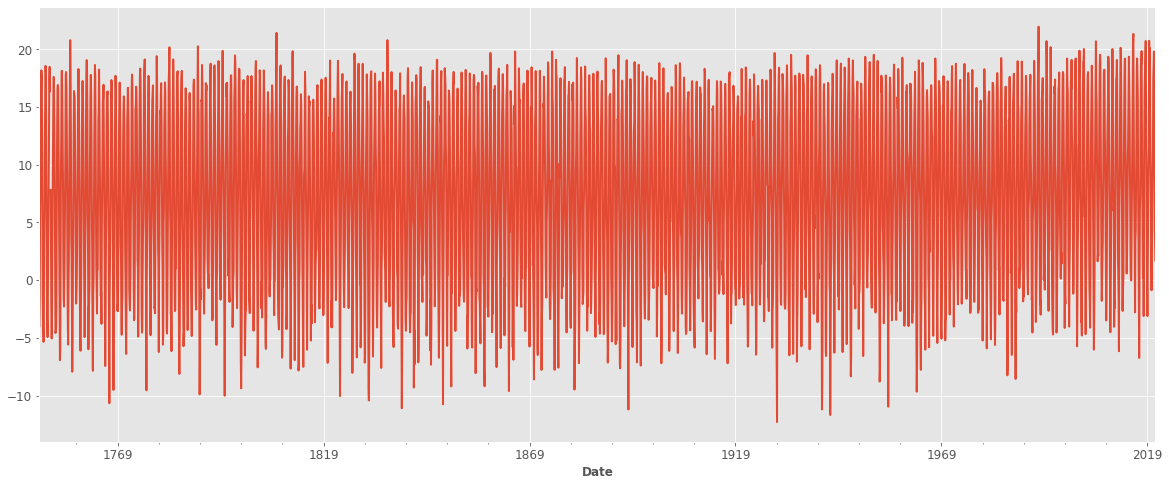

In [12]:
plt.rcParams['figure.figsize'] = [20, 8]
df.MonthlyAverage.plot()

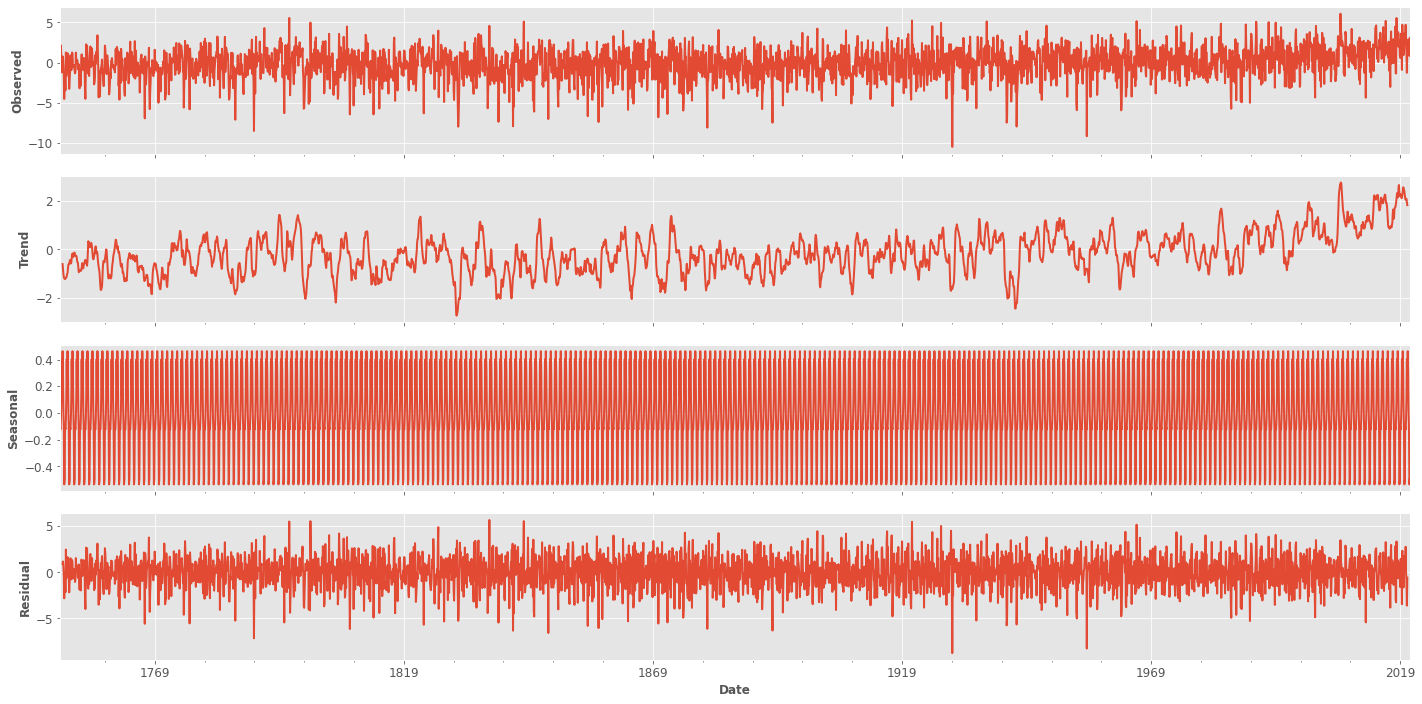

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
seasonal_decompose(df_anom).plot();

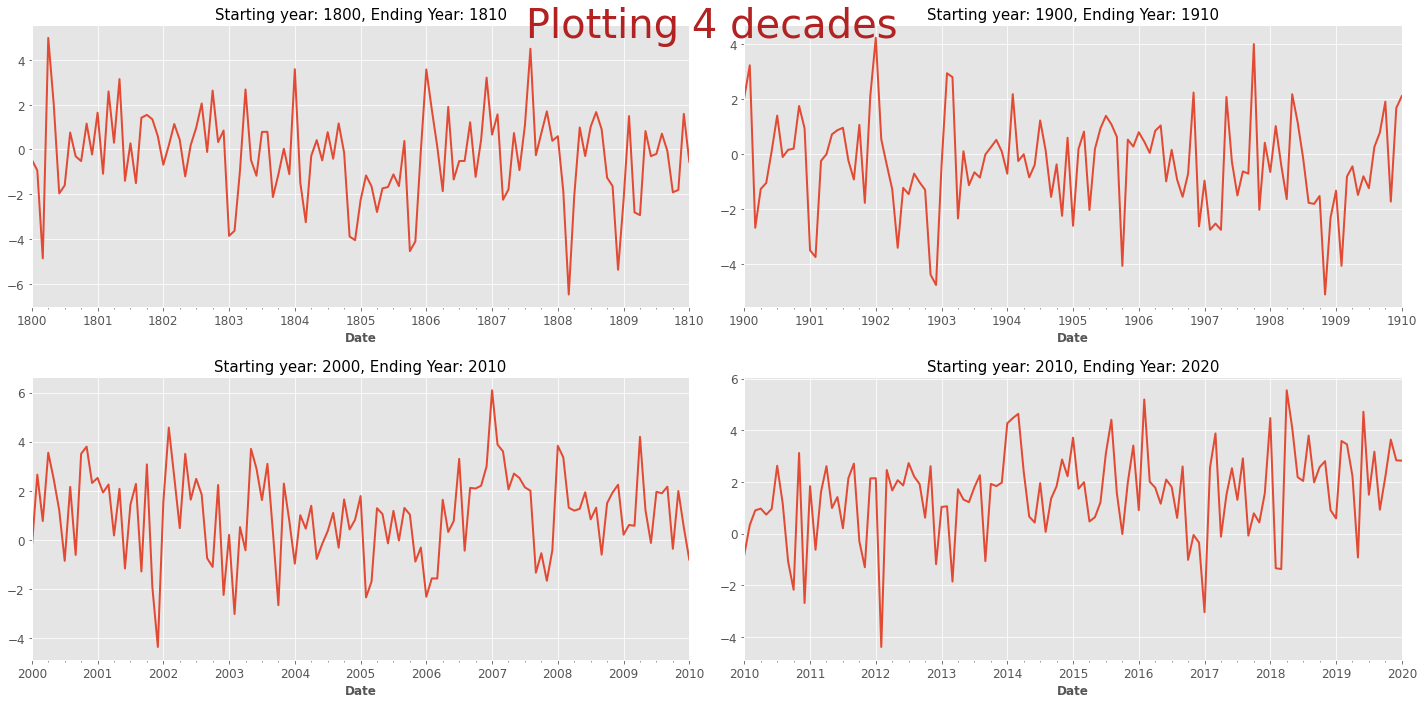

In [14]:
plt.figure(figsize=(20,10))
plt.suptitle('Plotting 4 decades',fontsize=40,color='firebrick')

plt.subplot(2,2,1)
plt.title('Starting year: 1800, Ending Year: 1810',fontsize=15)
df.MonthlyAnomaly[datetime.datetime(1800, 1, 1):datetime.datetime(1810, 1, 1)].plot()
plt.subplot(2,2,2)
plt.title('Starting year: 1900, Ending Year: 1910',fontsize=15)
df.MonthlyAnomaly[datetime.datetime(1900, 1, 1):datetime.datetime(1910, 1, 1)].plot()
plt.subplot(2,2,3)
plt.title('Starting year: 2000, Ending Year: 2010',fontsize=15)
df.MonthlyAnomaly[datetime.datetime(2000, 1, 1):datetime.datetime(2010, 1, 1)].plot()
plt.subplot(2,2,4)
plt.title('Starting year: 2010, Ending Year: 2020',fontsize=15)
df.MonthlyAnomaly[datetime.datetime(2010, 1, 1):datetime.datetime(2020, 1, 1)].plot()
plt.tight_layout()

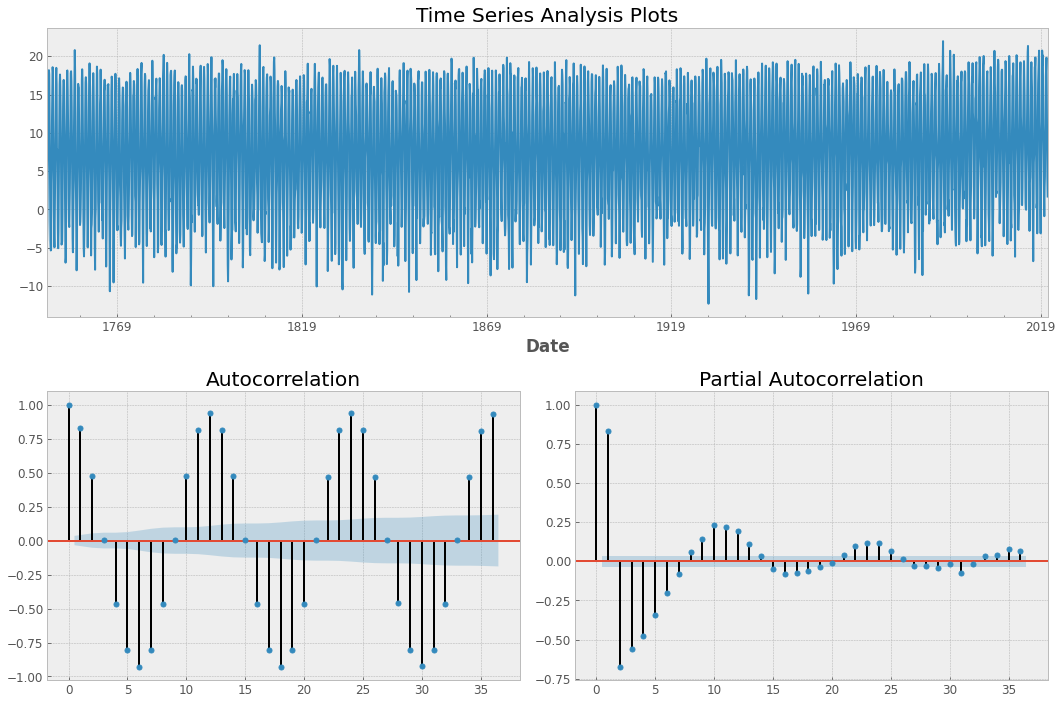

In [27]:
tsplot(df.MonthlyAverage.fillna(method='bfill'))

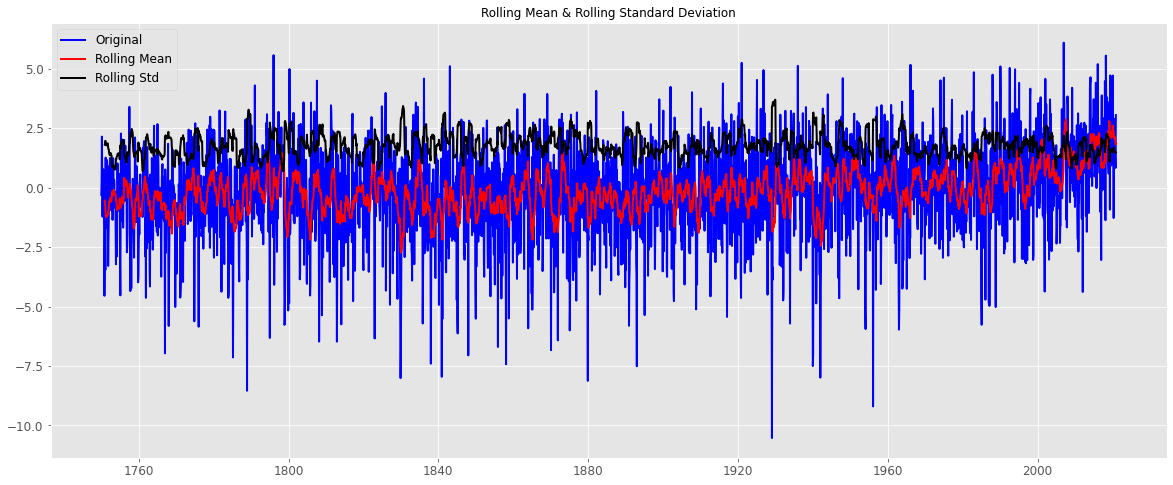

In [16]:
plt.rcParams['figure.figsize'] = [20, 8]
rolling_mean = df_anom.rolling(window = 12).mean()
rolling_std = df_anom.rolling(window = 12).std()
plt.plot(df_anom, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: \t{}'.format(key, value))

In [17]:
df_anom.describe()

count    3252.000000
mean       -0.156428
std         1.940129
min       -10.527000
25%        -1.265500
50%        -0.054000
75%         1.111250
max         6.090000
Name: MonthlyAnomaly, dtype: float64

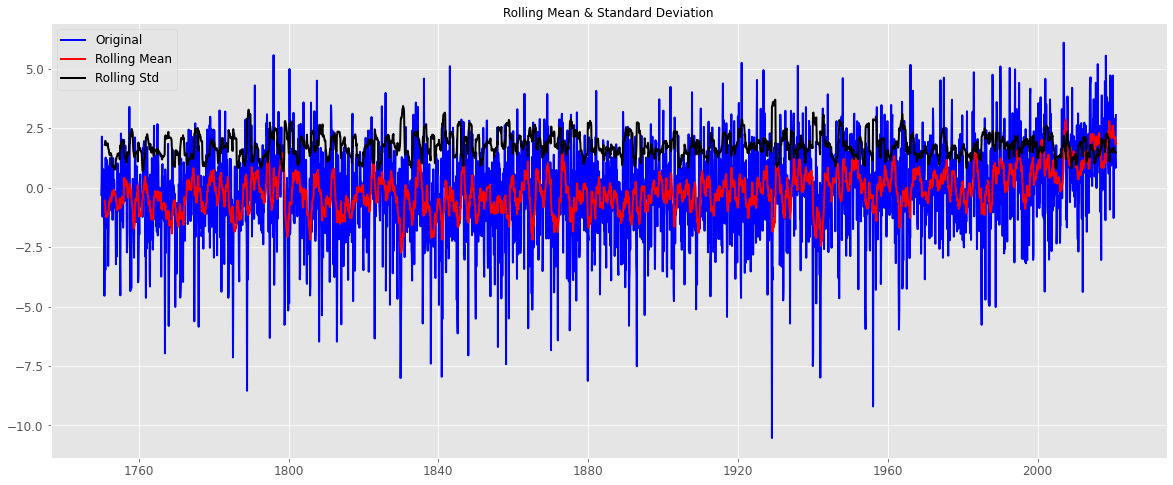

ADF Statistic: -7.187733241135054
p-value: 2.5507472618401086e-10
Critical Values:
	1%: 	-3.432378047525015
	5%: 	-2.862436069383185
	10%: 	-2.5672469973560355


In [18]:
get_stationarity(df_anom)

In [20]:
print(adfuller(df_anom))

(-7.187733241135054, 2.5507472618401086e-10, 24, 3227, {'1%': -3.432378047525015, '5%': -2.862436069383185, '10%': -2.5672469973560355}, 13133.661243394237)


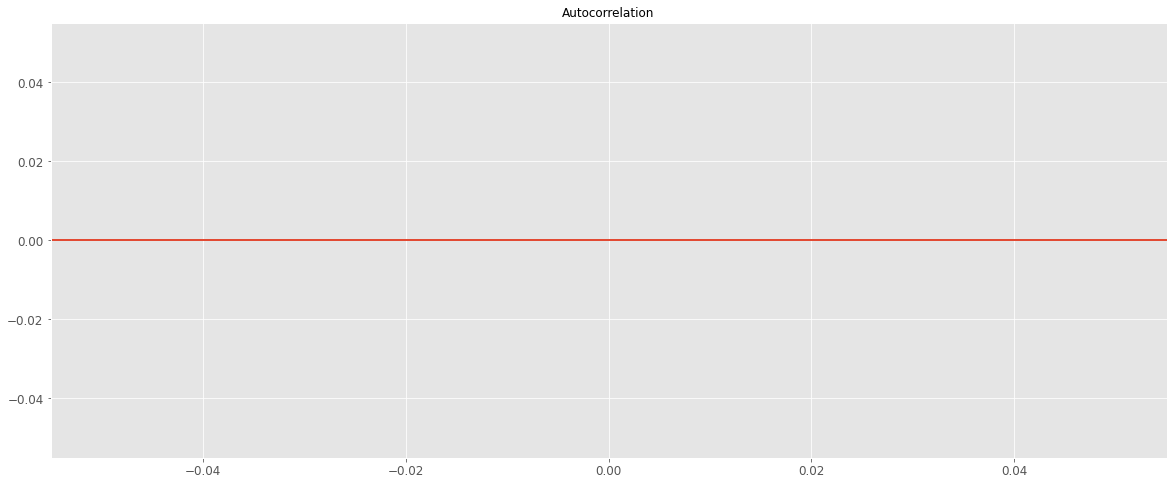

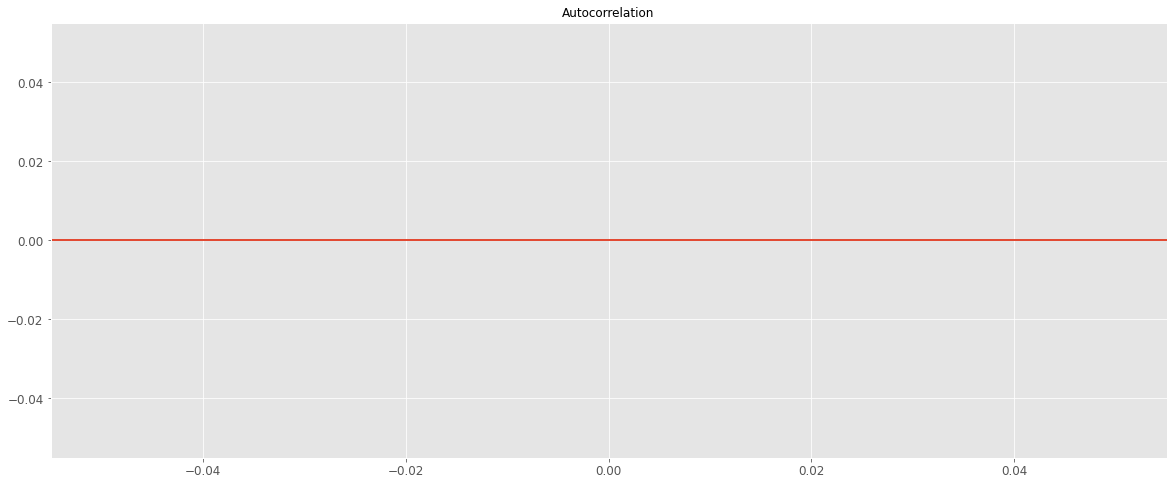

In [23]:
plot_acf(df.MonthlyAverage)